In [11]:
import pandas as pd
import numpy as np

In [16]:
drinks = pd.read_csv('WHO_data_alc.csv')

C:\Users\janno\AppData\Local\Temp\ipykernel_24488\329239668.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  drinks = pd.read_csv('WHO_data_alc.csv')


In [17]:
drinks

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,SA_0000001400,"Alcohol, recorded per capita (15+) consumption...",numeric,EMR,Eastern Mediterranean,Country,AFG,Afghanistan,Year,2019,...,NaN,NaN,0.0,NaN,0.0,0 [0 – 0],NaN,NaN,EN,2022-06-12T23:00:00.000Z
1,SA_0000001400,"Alcohol, recorded per capita (15+) consumption...",numeric,EMR,Eastern Mediterranean,Country,AFG,Afghanistan,Year,2019,...,NaN,NaN,0.0,NaN,0.0,0 [0 – 0],NaN,NaN,EN,2022-06-12T23:00:00.000Z
2,SA_0000001400,"Alcohol, recorded per capita (15+) consumption...",numeric,EMR,Eastern Mediterranean,Country,AFG,Afghanistan,Year,2019,...,NaN,NaN,0.0,NaN,0.0,0 [0 – 0],NaN,NaN,EN,2022-06-12T23:00:00.000Z
3,SA_0000001400,"Alcohol, recorded per capita (15+) consumption...",numeric,AFR,Africa,Country,DZA,Algeria,Year,2019,...,NaN,NaN,0.0,NaN,0.0,0 [0 – 0],NaN,NaN,EN,2022-06-12T23:00:00.000Z
4,SA_0000001400,"Alcohol, recorded per capita (15+) consumption...",numeric,EUR,Europe,Country,AND,Andorra,Year,2019,...,NaN,NaN,0.0,NaN,0.0,0 [0 – 0],NaN,NaN,EN,2022-06-12T23:00:00.000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47784,SA_0000001400,"Alcohol, recorded per capita (15+) consumption...",numeric,AMR,Americas,Country,USA,United States of America,Year,1960,...,NaN,NaN,NaN,NaN,NaN,3.26,NaN,NaN,EN,2018-05-10T23:00:00.000Z
47785,SA_0000001400,"Alcohol, recorded per capita (15+) consumption...",numeric,AMR,Americas,Country,USA,United States of America,Year,1960,...,NaN,NaN,NaN,NaN,NaN,3.75,NaN,NaN,EN,2018-05-10T23:00:00.000Z
47786,SA_0000001400,"Alcohol, recorded per capita (15+) consumption...",numeric,EUR,Europe,Country,AUT,Austria,Year,1960,...,NaN,NaN,NaN,NaN,NaN,4.7,NaN,NaN,EN,2018-05-10T23:00:00.000Z
47787,SA_0000001400,"Alcohol, recorded per capita (15+) consumption...",numeric,AMR,Americas,Country,USA,United States of America,Year,1960,...,NaN,NaN,NaN,NaN,NaN,7.83,NaN,NaN,EN,2018-05-10T23:00:00.000Z


In [8]:
drinks['country'][drinks['total_litres_of_pure_alcohol'].idxmax()]

'Belarus'

Matplotlib is building the font cache; this may take a moment.


<Axes: >

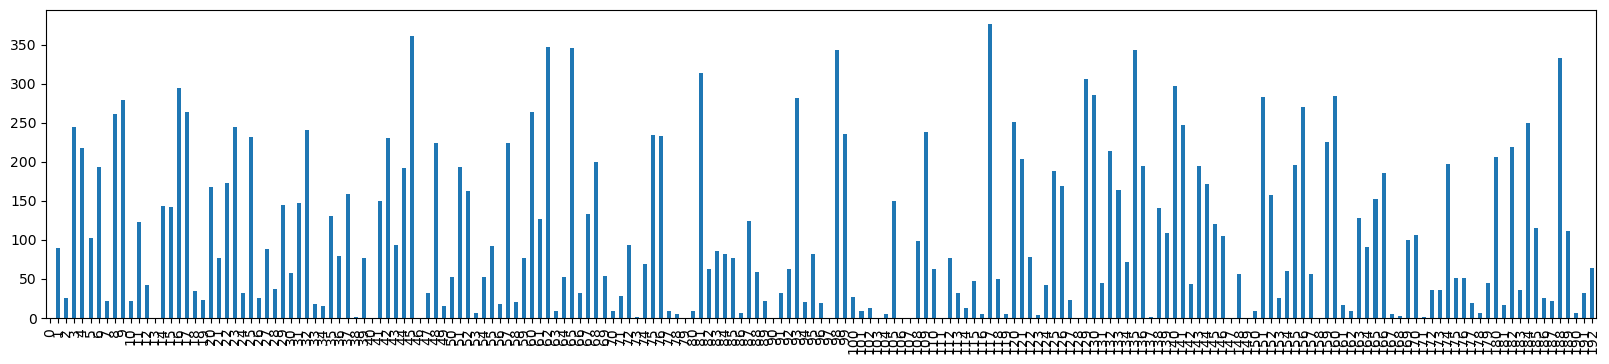

In [5]:
drinks['beer_servings'].plot(kind='bar', figsize=(20,4))

In [19]:
gdp = pd.read_csv('gdp.csv')
gdp_grth = pd.read_csv("gdp_growth.csv")
gdp_pc = pd.read_csv("gdp_per_capita.csv")
gdp_pc_grth = pd.read_csv("gdp_per_capita_growth.csv")
gdp_ppp = pd.read_csv("gdp_ppp.csv")
gdp_pc_ppp = pd.read_csv("gdp_ppp_per_capita.csv")
#a